In [310]:
# Cryptocurrency Analysis Script v002

import requests
import pandas as pd
import numpy as np
import io
from datetime import datetime, timedelta
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio

# Constants
API_KEY = '2lZRFGaqFiEYkzr7WUuT4EaoC1X'  # Replace with your actual API key
SINCE_DATE = int(datetime(2014, 1, 1).timestamp())  # Jan 1, 2015
UNTIL_DATE = int(datetime.now().timestamp())  # Current date

# URLs for fetching data
PRICE_URL = 'https://api.glassnode.com/v1/metrics/market/price_usd_close'
METRICS = [
    'https://api.glassnode.com/v1/metrics/indicators/investor_capitalization',
    'https://api.glassnode.com/v1/metrics/supply/current',
    'https://api.glassnode.com/v1/metrics/indicators/liveliness',
    'https://api.glassnode.com/v1/metrics/indicators/realized_profit_lth_account_based',
    'https://api.glassnode.com/v1/metrics/indicators/realized_loss_lth_account_based',
    'https://api.glassnode.com/v1/metrics/supply/profit_relative'
]

def fetch_glassnode_data(url, asset='BTC'):
    params = {
        'a': asset,
        's': SINCE_DATE,
        'u': UNTIL_DATE,
        'api_key': API_KEY,
        'f': 'CSV',
        'c': 'USD'
    }

    response = requests.get(url, params=params)
    if response.status_code == 200:
        df = pd.read_csv(io.StringIO(response.text))
        metric_name = url.split('/')[-1]
        df.columns = ['t', metric_name]
        df['t'] = pd.to_datetime(df['t'], unit='s')
        df[metric_name] = pd.to_numeric(df[metric_name], errors='coerce')
        return df
    else:
        print(f"Failed to fetch data from {url}. Status code: {response.status_code}")
        return None

# Fetch and merge data
price_df = fetch_glassnode_data(PRICE_URL)
all_dfs = [price_df]
for metric_url in METRICS:
    metric_df = fetch_glassnode_data(metric_url)
    if metric_df is not None:
        all_dfs.append(metric_df)

merged_df = pd.concat(all_dfs, axis=1)
merged_df = merged_df.loc[:,~merged_df.columns.duplicated()]
merged_df.set_index('t', inplace=True)

In [311]:

def calculate_supplyinprofit_percentile(df, column='profit_relative', perc_window=1400, norm_window=1400, normalization='maxmin'):
    # Calculate percentile
    percentile = df[column].rolling(window=perc_window).apply(
        lambda x: pd.Series(x).rank(pct=True).iloc[-1]
    )
    
    if normalization == False:
        return percentile
    elif normalization == 'maxmin':
        max_val = percentile.rolling(window=norm_window).max()
        min_val = percentile.rolling(window=norm_window).min()
        normalized_percentile = 2 * (percentile - min_val) / (max_val - min_val) - 1
    elif normalization == 'z-score':
        mean = percentile.rolling(window=norm_window).mean()
        std = percentile.rolling(window=norm_window).std()
        z_score = (percentile - mean) / std
        # Scale z-score to -1 to +1 range
        normalized_percentile = z_score / z_score.abs().max()
    else:
        raise ValueError("Invalid normalization method. Choose 'False', 'maxmin', or 'z-score'.")
    
    return normalized_percentile

In [312]:

def calculate_aviv_percentile(df, columns=['investor_capitalization', 'current', 'liveliness', 'price_usd_close'], perc_window=1400, norm_window=1400, normalization='maxmin'):
    # Calculate AVIV
    aviv = df[columns[2]] * df[columns[1]] * df[columns[3]] / df[columns[0]]
    
    # Calculate percentile
    percentile = aviv.rolling(window=perc_window).apply(
        lambda x: pd.Series(x).rank(pct=True).iloc[-1]
    )
    
    if normalization == False:
        return percentile
    elif normalization == 'maxmin':
        max_val = percentile.rolling(window=norm_window).max()
        min_val = percentile.rolling(window=norm_window).min()
        normalized_percentile = 2 * (percentile - min_val) / (max_val - min_val) - 1
    elif normalization == 'z-score':
        mean = percentile.rolling(window=norm_window).mean()
        std = percentile.rolling(window=norm_window).std()
        z_score = (percentile - mean) / std
        # Scale z-score to -1 to +1 range
        normalized_percentile = z_score / z_score.abs().max()
    else:
        raise ValueError("Invalid normalization method. Choose 'False', 'maxmin', or 'z-score'.")
    
    return normalized_percentile

In [313]:

def calculate_lthrealized_plratio_logpercentile(df, columns=['realized_profit_lth_account_based', 'realized_loss_lth_account_based'], perc_window=1400, norm_window=1400, normalization='maxmin'):
    # Calculate LTH realized P/L ratio
    lth_realized_pl = df[columns[0]] / df[columns[1]]
    
    # Apply log transformation
    log_lth_realized_pl = np.log(lth_realized_pl)
    
    # Calculate percentile
    percentile = log_lth_realized_pl.rolling(window=perc_window).apply(
        lambda x: pd.Series(x).rank(pct=True).iloc[-1]
    )
    
    if normalization == False:
        return percentile
    elif normalization == 'maxmin':
        max_val = percentile.rolling(window=norm_window).max()
        min_val = percentile.rolling(window=norm_window).min()
        normalized_percentile = 2 * (percentile - min_val) / (max_val - min_val) - 1
    elif normalization == 'z-score':
        mean = percentile.rolling(window=norm_window).mean()
        std = percentile.rolling(window=norm_window).std()
        z_score = (percentile - mean) / std
        # Scale z-score to -1 to +1 range
        normalized_percentile = z_score / z_score.abs().max()
    else:
        raise ValueError("Invalid normalization method. Choose 'False', 'maxmin', or 'z-score'.")
    
    return normalized_percentile

In [314]:

# Apply the functions to the merged dataframe with maxmin normalization
merged_df['supplyinprofit_percentile_maxmin'] = calculate_supplyinprofit_percentile(merged_df, normalization='maxmin')
merged_df['aviv_percentile_maxmin'] = calculate_aviv_percentile(merged_df, normalization='maxmin')
merged_df['lthrealized_plratio_logpercentile_maxmin'] = calculate_lthrealized_plratio_logpercentile(merged_df, normalization='maxmin')

In [315]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def aggregate_indicators(df, columns, method='equal_weight'):
    """
    Aggregate financial behavior indicators from a DataFrame, excluding initial rows with NaN values.
    
    :param df: pandas DataFrame containing the indicators
    :param columns: list of column names to be aggregated
    :param method: 'equal_weight' or 'PCA'
    :return: pandas Series with the aggregated indicator
    """
    # Ensure all specified columns exist in the DataFrame
    if not all(col in df.columns for col in columns):
        raise ValueError("Some specified columns are not in the DataFrame")
    
    # Extract the relevant columns
    data = df[columns]
    
    if method == 'equal_weight':
        # For equal weight, we can use pandas mean which automatically skips NaN
        weight = 1 / len(columns)
        print(f"weights are all equal = {weight:.4f}")
        return data.mean(axis=1)
    
    elif method == 'PCA':
        # Remove rows with any NaN values
        data_clean = data.dropna()
        
        if len(data_clean) == 0:
            raise ValueError("No complete rows found after removing NaN values")
        
        # Standardize the data
        scaler = StandardScaler()
        data_scaled = scaler.fit_transform(data_clean)
        
        # Perform PCA
        pca = PCA(n_components=1)
        pca_result = pca.fit_transform(data_scaled)
        
        # Calculate weights from the first principal component
        weights = pca.components_[0] / np.sum(np.abs(pca.components_[0]))
        
        print("PCA weights:")
        for col, weight in zip(columns, weights):
            print(f"{col}: {weight:.4f}")
        
        # Calculate weighted sum for all rows, including those with NaN
        weighted_sum = data.mul(weights).sum(axis=1)
        
        # Normalize the weighted sum to be in the same range as input data
        min_val, max_val = data.min().min(), data.max().max()
        normalized_sum = (weighted_sum - weighted_sum.min()) / (weighted_sum.max() - weighted_sum.min())
        normalized_sum = normalized_sum * (max_val - min_val) + min_val
        
        return normalized_sum
    
    else:
        raise ValueError("Invalid method. Choose 'equal_weight' or 'PCA'")


In [316]:

merged_df['aggregate_indicator_equalweight']= aggregate_indicators(merged_df, columns=['lthrealized_plratio_logpercentile_maxmin','aviv_percentile_maxmin','supplyinprofit_percentile_maxmin'], method='equal_weight')
merged_df['aggregate_indicator_PCA']= aggregate_indicators(merged_df, columns=['lthrealized_plratio_logpercentile_maxmin','aviv_percentile_maxmin','supplyinprofit_percentile_maxmin'], method='PCA')

weights are all equal = 0.3333
PCA weights:
lthrealized_plratio_logpercentile_maxmin: 0.3316
aviv_percentile_maxmin: 0.3338
supplyinprofit_percentile_maxmin: 0.3345


In [317]:
# Visualization section
def create_indicator_chart(merged_df, indicator_column, chart_title):
    # Filter data for the last year
    one_year_ago = datetime.now() - timedelta(days=365)
    merged_df_last_year = merged_df[merged_df.index > one_year_ago]

    # Define a consistent grey color
    GREY_COLOR = 'rgba(128, 128, 128, 0.7)'  # Semi-transparent grey

    # Create the visualization
    fig = make_subplots(specs=[[{"secondary_y": True}]])

    # Add price trace
    fig.add_trace(
        go.Scatter(x=merged_df_last_year.index, y=merged_df_last_year['price_usd_close'], name="Price USD", line=dict(color=GREY_COLOR, width=2), mode='lines'),
        secondary_y=False,
    )

    # Add indicator trace
    indicator = merged_df_last_year[indicator_column]
    fig.add_trace(
        go.Scatter(
            x=merged_df_last_year.index,
            y=indicator,
            name=indicator_column,
            line=dict(color='green', width=2),
            fill='tozeroy',
            fillcolor='rgba(0,255,0,0.1)',
            mode='lines'
        ),
        secondary_y=True,
    )

    # Add red color for negative values
    fig.add_trace(
        go.Scatter(
            x=merged_df_last_year.index,
            y=indicator.where(indicator < 0, 0),
            name=f"{indicator_column} (Negative)",
            line=dict(color='red', width=2),
            fill='tozeroy',
            fillcolor='rgba(255,0,0,0.1)',
            mode='lines'
        ),
        secondary_y=True,
    )

    # Add y=0 line on top (without adding to legend)
    fig.add_trace(
        go.Scatter(
            x=merged_df_last_year.index,
            y=[0] * len(merged_df_last_year),
            showlegend=False,
            line=dict(color=GREY_COLOR, width=2),
            hoverinfo='skip'
        ),
        secondary_y=True,
    )

    # Add vertical lines for every two months (Jan, Mar, May, Jul, Sep, Nov)
    for month in [1, 3, 5, 7, 9, 11]:
        for year in range(merged_df_last_year.index[0].year, merged_df_last_year.index[-1].year + 1):
            date = pd.Timestamp(year=year, month=month, day=1)
            if merged_df_last_year.index[0] <= date <= merged_df_last_year.index[-1]:
                fig.add_vline(x=date, line_dash="dash", line_color=GREY_COLOR, line_width=0.75, opacity=0.7)

    # Get the last value of the indicator
    last_value = indicator.iloc[-1]
    last_date = indicator.index[-1]

    # Determine the color based on the last value
    indicator_color = 'green' if last_value >= 0 else 'red'

    # Add annotation for the last value
    fig.add_annotation(
        x=0.95,  # Place at the right edge of the chart
        y=last_value*0.88,  # Place at the vertical position of the last value
        xref="paper",
        yref="y2",  # Use the secondary y-axis for reference
        text=f"{last_value:.2f}",
        showarrow=False,
        font=dict(size=18, color=indicator_color),
        align="left",
        xanchor="left",
        yanchor="middle",
    )

    # Update layout
    fig.update_layout(
        title={
            'text': chart_title,
            'font': {'color': 'black', 'size': 18, 'weight': 'bold'}
        },
        xaxis_title={
            'text': "Date",
            'font': {'color': 'black', 'size': 18}
        },
        showlegend=False,  # Remove legend
        hovermode="x unified",
        plot_bgcolor='white',
        paper_bgcolor='white',
        font={'color': 'black', 'size': 14},
        width=1000,  # Set width for 16:9 aspect ratio
        height=450,  # Set height for 16:9 aspect ratio
    )

    # Update axes
    fig.update_xaxes(
        showgrid=False, 
        tickfont={'color': 'black', 'size': 14},
        zeroline=False
    )
    fig.update_yaxes(
        showgrid=False, 
        secondary_y=False, 
        tickfont={'color': GREY_COLOR, 'size': 14},
        zeroline=False,
        showline=True,
        linecolor=GREY_COLOR,
        ticks='outside',
        tickcolor=GREY_COLOR,
        title_text='',
        title_font=dict(size=18)
    )
    fig.update_yaxes(
        showgrid=False, 
        secondary_y=True, 
        range=[-1, 1], 
        tickfont={'color': GREY_COLOR, 'size': 14},
        zeroline=False,
        showline=True,
        linecolor=GREY_COLOR,
        ticks='outside',
        side='right',
        tickcolor=GREY_COLOR,
        title_text='',
        title_font=dict(size=18)
    )

    return fig

# Assuming merged_df is your dataframe containing all the necessary data
# If you haven't created merged_df yet, you need to do that before this visualization part

# Create charts for each indicator
indicators = [
    ('supplyinprofit_percentile_maxmin', "Bitcoin: Supply in Profit"),
    ('aviv_percentile_maxmin', "Bitcoin: AVIV"),
    ('lthrealized_plratio_logpercentile_maxmin', "Bitcoin: LTH Realized P/L Ratio"),
    ('aggregate_indicator_equalweight', "Bitcoin: Aggregate Indicator Equal Weight"),
    ('aggregate_indicator_PCA', "Bitcoin: Aggregate Indicator PCA")
]

for indicator, title in indicators:
    fig = create_indicator_chart(merged_df, indicator, title)
    
    # Show the plot
    fig.show()
    
    # Optionally, save the plot as an HTML file
    pio.write_html(fig, file=f'bitcoin_analysis_{indicator}_last_year.html')

print("All charts have been displayed and saved as separate HTML files.")

All charts have been displayed and saved as separate HTML files.


In [318]:
merged_df.tail()

,price_usd_close,investor_capitalization,current,liveliness,realized_profit_lth_account_based,realized_loss_lth_account_based,profit_relative,supplyinprofit_percentile_maxmin,aviv_percentile_maxmin,lthrealized_plratio_logpercentile_maxmin,aggregate_indicator_equalweight,aggregate_indicator_PCA
t,,,,,,,,,,,,
2024-09-23,63322.551391,5.621972e+11,1.251965e+12,0.609135,5.940004e+08,3.979261e+06,0.853964,0.391931,0.490129,0.376252,0.419437,0.440519
2024-09-24,64338.712500,5.625841e+11,1.270186e+12,0.609074,2.131878e+08,6.788349e+06,0.880322,0.510086,0.512446,0.147353,0.389962,0.410848
2024-09-25,63078.050802,5.634138e+11,1.246357e+12,0.609079,4.965178e+08,1.272868e+06,0.836627,0.319885,0.478112,0.433476,0.410491,0.431149
2024-09-26,65134.209238,5.641309e+11,1.283282e+12,0.609146,4.260703e+08,2.412433e+06,0.887682,0.544669,0.538197,0.390558,0.491141,0.514244
2024-09-27,65767.337050,5.647985e+11,1.299089e+12,0.609110,3.070725e+08,1.180856e+06,0.891478,0.556196,0.557082,0.410587,0.507955,0.531475


In [319]:
merged_df.to_csv('bitcoin_analysis_data_lth.csv', index=True)

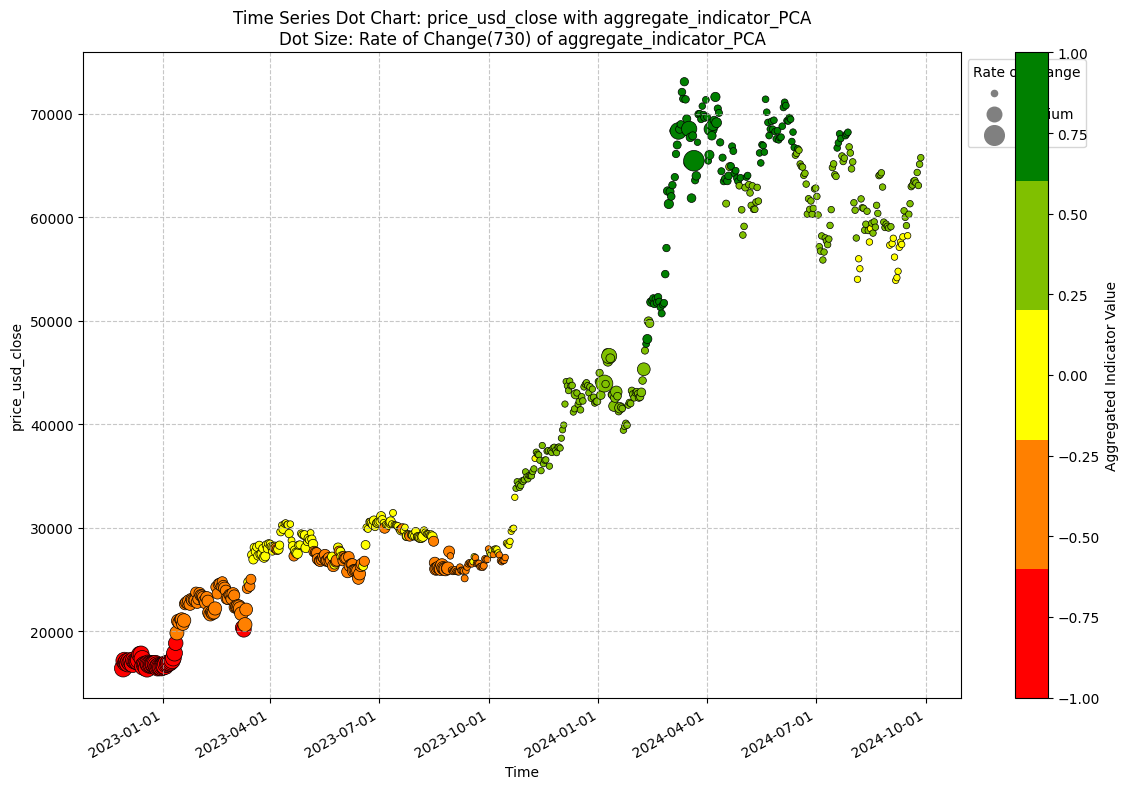

In [321]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.colors import LinearSegmentedColormap
from datetime import datetime, timedelta

def create_dot_chart(df, aggregated_column, price_column, change_window=1, n_bins=10):
    """
    Create a time series dot chart visualization of the price,
    with dot color representing the aggregated indicator and
    dot size representing the rate of change of the aggregated indicator.
    
    :param df: pandas DataFrame containing the data
    :param aggregated_column: name of the column with aggregated indicator values
    :param price_column: name of the column with price data
    :param change_window: number of periods to consider for rate of change calculation (default: 1)
    :param n_bins: number of color bins for the colormap (default: 10)
    :return: matplotlib figure object
    """
    # Ensure the required columns exist in the DataFrame
    if aggregated_column not in df.columns or price_column not in df.columns:
        raise ValueError("Specified columns not found in the DataFrame")
    
    # Create a copy of the DataFrame to avoid SettingWithCopyWarning
    plot_df = df.copy()
    
    # Calculate the rate of change of the aggregated indicator
    plot_df['rate_of_change'] = plot_df[aggregated_column].pct_change(periods=change_window)
    
    # Take absolute value of rate of change for dot sizes
    plot_df['abs_rate_of_change'] = np.abs(plot_df['rate_of_change'])
    
    # Normalize the absolute rate of change to use for dot sizes
    plot_df['normalized_change'] = (plot_df['abs_rate_of_change'] - plot_df['abs_rate_of_change'].min()) / (plot_df['abs_rate_of_change'].max() - plot_df['abs_rate_of_change'].min())
    
    # Create a custom colormap: red (-1) to yellow (0) to green (1)
    colors = ['red', 'yellow', 'green']
    cmap = LinearSegmentedColormap.from_list('custom', colors, N=n_bins)
    
    # Create the plot with a white background
    fig, ax = plt.subplots(figsize=(12, 8), facecolor='white')
    ax.set_facecolor('white')
    
    scatter = ax.scatter(plot_df.index, 
                         plot_df[price_column], 
                         c=plot_df[aggregated_column], 
                         s=plot_df['normalized_change'] * 200 + 20,  # Scale size based on rate of change
                         cmap=cmap, 
                         vmin=-1, 
                         vmax=1,
                         edgecolors='black',  # Add black edge to dots for better visibility
                         linewidths=0.5)
    
    # Customize the plot
    cbar = plt.colorbar(scatter, label='Aggregated Indicator Value')
    cbar.ax.yaxis.label.set_color('black')  # Set colorbar label color to black
    cbar.ax.tick_params(colors='black')  # Set colorbar tick color to black
    
    ax.set_xlabel('Time', color='black')
    ax.set_ylabel(price_column, color='black')
    ax.set_title(f'Time Series Dot Chart: {price_column} with {aggregated_column}\nDot Size: Rate of Change({change_window}) of {aggregated_column}', color='black')
    
    # Format x-axis to show dates nicely
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    fig.autofmt_xdate()  # Rotate and align the tick labels
    
    # Set tick colors to black
    ax.tick_params(axis='x', colors='black')
    ax.tick_params(axis='y', colors='black')
    
    # Add gridlines for better readability
    ax.grid(True, linestyle='--', alpha=0.7)
    
    # Add rate of change legend
    sizes = [20, 110, 200]
    labels = ['Low', 'Medium', 'High']
    legend_elements = [plt.scatter([], [], s=size, c='gray', label=label) for size, label in zip(sizes, labels)]
    ax.legend(handles=legend_elements, title='Rate of Change', loc='upper left', bbox_to_anchor=(1, 1))
    
    # Adjust layout and return the figure
    plt.tight_layout()
    return fig

# Example usage
# Assuming 'merged_df' is your DataFrame with the aggregated indicator and price data
# merged_df.index should be a DatetimeIndex
# Create a copy of the slice to avoid the warning
plot_data = merged_df[merged_df.index > datetime.now() - timedelta(days=1400)].copy()
fig = create_dot_chart(plot_data, 
                       'aggregate_indicator_PCA', 
                       'price_usd_close', 
                       change_window=730,  # Calculate day-over-day change
                       n_bins=5)
plt.show()